# Assignment 3

Name        : Chia Sin Liew  
Last edited : April 18th, 2022

The goal of this assignment is to solve multi-class classification problems, visualization of image samples, and analyzing errors.
- **Part A**: Multi-class Classification – Structured Data
- **Part B**: Multi-class Classification – Unstructured Data & Analysis of Model
Errors

## Part A: Multi-class Classification - Structured Data

You will perform multi-class classification on the following dataset using the Logistic Regression and KNN models.  

Your goal is to: 
- Maximize test accuracy as well as precision, recall & F1 score for each class

**Dataset**:
The dataset, given in the *winequality-white.csv* file, is related to the white variants of the Portuguese "Vinho Verde"" wine. It provides the physicochemical (inputs) and sensory (the output) variables. The dataset consists of characteristics of white wine (e.g., alcohol content, density, amount of citric acid, pH, etc.) with target variable "quality" representing rating of wine. The target variable "quality" ranges from 3 to 9. Higher rating indicates better quality of a wine. The classes are ordered and not balanced (e.g., there are much more normal wines than excellent or poor ones).

Input features (based on physicochemical tests):
- fixed acidity
- volatile acidity
- citric acid
- residual sugar
- chlorides
- free sulfur dioxide
- total sulfur dioxide
- density
- pH
- sulphates
- alcohol

In [28]:
import pandas as pd
import os, sys 
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import SGDRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, classification_report
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

### Pre-processing:
- Load the CSV file as a Pandas DataFrame object.

In [29]:
df = pd.read_excel("winequality-white.xlsx")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7


In [30]:
# keep a dictionary of column index to column name for easier
# subsetting later in feature selection
col_name_list = df.columns.to_list()
col_name_dict = {elem : i for i, elem in enumerate(col_name_list)}

- Create a data frame object for the features and another data frame object for the target.

In [31]:
# y for target
y = df['quality'].to_frame()
# X for features
X = df.drop(columns=['quality'])

print("\nData frame for features (X): \n", X.iloc[:6, :5])
print("\nDimension of X: ", X.shape)
print("\nData frame for target(Y): \n", y)
print("\nDimension of Y: ", y.shape)


Data frame for features (X): 
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides
0            7.0              0.27         0.36            20.7      0.045
1            6.3              0.30         0.34             1.6      0.049
2            8.1              0.28         0.40             6.9      0.050
3            7.2              0.23         0.32             8.5      0.058
4            7.2              0.23         0.32             8.5      0.058
5            8.1              0.28         0.40             6.9      0.050

Dimension of X:  (4898, 11)

Data frame for target(Y): 
       quality
0           6
1           6
2           6
3           6
4           6
...       ...
4893        6
4894        5
4895        6
4896        7
4897        6

[4898 rows x 1 columns]

Dimension of Y:  (4898, 1)


- Create a **bar plot** to display the class distribution.

Text(0, 0.5, 'Counts')

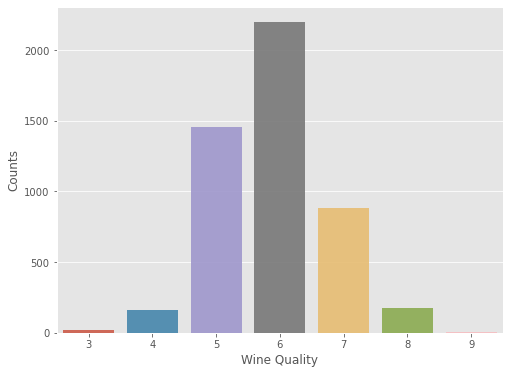

In [32]:
label_counts = df.quality.value_counts()
label_counts
plt.figure(figsize = (8,6))
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

plt.xlabel('Wine Quality', fontsize=12)
plt.ylabel('Counts', fontsize=12)

- Convert the above two DataFrame objects into two NumPy arrays (you may use the NumPy “asarray” function).
- Convert the target array type into “int”.

In [33]:
X = np.asarray(X)
y = np.asarray(y).ravel()

print("\nX data type: ", X.dtype)
print("Y data type: ", y.dtype)

y = y.astype('int')

print("\nY data type (after conversion): ", y.dtype)


X data type:  float64
Y data type:  int64

Y data type (after conversion):  int64


- Partition the dataset into training & test subsets: 80% training & 20% test (you may use Scikit-Learn’s train_test_split() function).

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3918, 11)
(980, 11)
(3918,)
(980,)


### Feature Selection:
You need to use the optimal set of features for the Logistic Regression models, which may consist of all features or a subset. Note that dropping the poorly correlated features with the target may not necessarily improve the test performance. You need to determine the optimal feature set empirically.

In [35]:
# create a dataframe from X_train
df_train = pd.DataFrame(np.concatenate((X_train, np.reshape(y_train, (3918, 1))), axis=1), 
                       columns=list(col_name_dict.keys()))
df_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,6.1,0.410,0.04,1.3,0.036,23.0,121.0,0.99228,3.24,0.61,9.9,6.0
1,8.6,0.170,0.28,2.7,0.047,38.0,150.0,0.99365,3.10,0.56,10.8,6.0
2,7.6,0.360,0.49,11.3,0.046,87.0,221.0,0.99840,3.01,0.43,9.2,5.0
3,6.4,0.310,0.28,2.5,0.039,34.0,137.0,0.98946,3.22,0.38,12.7,6.0
4,5.8,0.200,0.24,1.4,0.033,65.0,169.0,0.99043,3.59,0.56,12.3,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3913,6.1,0.105,0.31,1.3,0.037,55.0,145.0,0.99120,3.41,0.41,11.1,7.0
3914,6.6,0.370,0.07,1.4,0.048,58.0,144.0,0.99220,3.17,0.38,10.0,5.0
3915,6.9,0.160,0.30,9.6,0.057,50.0,185.0,0.99780,3.39,0.38,9.6,6.0
3916,6.4,0.160,0.42,1.0,0.036,29.0,113.0,0.99080,3.18,0.52,11.0,6.0


In [36]:
# calculate Pearson's correlation
corr_threshold = 0.00

feature_corr = df_train.corr()["quality"].sort_values(ascending=False)
print(feature_corr)

# Keep features above the selected threshold
print("\nKeep: \n")
retained_features = feature_corr[feature_corr.abs() >= corr_threshold]
print(retained_features)

# subset df
df_sub = df_train.loc[:, retained_features.index.to_list()]
df_sub

quality                 1.000000
alcohol                 0.433971
pH                      0.104504
sulphates               0.058670
free sulfur dioxide     0.024063
citric acid             0.002812
residual sugar         -0.086419
fixed acidity          -0.116735
total sulfur dioxide   -0.156923
volatile acidity       -0.186526
chlorides              -0.210236
density                -0.295684
Name: quality, dtype: float64

Keep: 

quality                 1.000000
alcohol                 0.433971
pH                      0.104504
sulphates               0.058670
free sulfur dioxide     0.024063
citric acid             0.002812
residual sugar         -0.086419
fixed acidity          -0.116735
total sulfur dioxide   -0.156923
volatile acidity       -0.186526
chlorides              -0.210236
density                -0.295684
Name: quality, dtype: float64


,quality,alcohol,pH,sulphates,free sulfur dioxide,citric acid,residual sugar,fixed acidity,total sulfur dioxide,volatile acidity,chlorides,density
0,6.0,9.9,3.24,0.61,23.0,0.04,1.3,6.1,121.0,0.410,0.036,0.99228
1,6.0,10.8,3.10,0.56,38.0,0.28,2.7,8.6,150.0,0.170,0.047,0.99365
2,5.0,9.2,3.01,0.43,87.0,0.49,11.3,7.6,221.0,0.360,0.046,0.99840
3,6.0,12.7,3.22,0.38,34.0,0.28,2.5,6.4,137.0,0.310,0.039,0.98946
4,7.0,12.3,3.59,0.56,65.0,0.24,1.4,5.8,169.0,0.200,0.033,0.99043
...,...,...,...,...,...,...,...,...,...,...,...,...
3913,7.0,11.1,3.41,0.41,55.0,0.31,1.3,6.1,145.0,0.105,0.037,0.99120
3914,5.0,10.0,3.17,0.38,58.0,0.07,1.4,6.6,144.0,0.370,0.048,0.99220
3915,6.0,9.6,3.39,0.38,50.0,0.30,9.6,6.9,185.0,0.160,0.057,0.99780
3916,6.0,11.0,3.18,0.52,29.0,0.42,1.0,6.4,113.0,0.160,0.036,0.99080


- rewrangle the dataframe back to numpy arrays and subset X_test

In [37]:
# Convert the selected features data frame into numpy arrays

# declare function to create feature and target arrays
def create_feature_target_arrays(df, target, drop_columns):
    # y for target
    y = df[target].to_frame()
    # X for features
    X = df.drop(columns=drop_columns)

    print("\nData frame for features(X): \n", X.iloc[:6, :5])
    print("\nDimension of X: ", X.shape)
    print("\nData frame for target(Y): \n", y)
    print("\nDimension of Y: ", y.shape)

    # convert into np arrays
    X = np.asarray(X)
    y = np.asarray(y).ravel()

    print("\nX data type: ", X.dtype)
    print("Y data type: ", y.dtype)
    
    y = y.astype('int')

    print("\nY data type (after conversion): ", y.dtype)
    
    return(X, y)

X_train, y_train = create_feature_target_arrays(df_sub, 'quality', ['quality'])


# subset the selected features for X_test
X_test = X_test[:, [col_name_dict[a] for a in df_sub.columns.to_list()[1:]]]

# check dimension of all data
print("\nData dimension: ")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


Data frame for features(X): 
    alcohol    pH  sulphates  free sulfur dioxide  citric acid
0      9.9  3.24       0.61                 23.0         0.04
1     10.8  3.10       0.56                 38.0         0.28
2      9.2  3.01       0.43                 87.0         0.49
3     12.7  3.22       0.38                 34.0         0.28
4     12.3  3.59       0.56                 65.0         0.24
5     12.1  3.35       0.47                 31.0         0.36

Dimension of X:  (3918, 11)

Data frame for target(Y): 
       quality
0         6.0
1         6.0
2         5.0
3         6.0
4         7.0
...       ...
3913      7.0
3914      5.0
3915      6.0
3916      6.0
3917      7.0

[3918 rows x 1 columns]

Dimension of Y:  (3918, 1)

X data type:  float64
Y data type:  float64

Y data type (after conversion):  int64

Data dimension: 
(3918, 11)
(980, 11)
(3918,)
(980,)


### Experiments:
You will perform multi-class classification using the following models. If a model requires the data to be standardized, you must do so prior training. You must perform hyperparameter tuning. For experiment 3, use the Pipeline object that will augment features, standardize (if required), and create a model.

##### Standardization

In [38]:
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_train)

# Apply transform to both the training and test sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Experiment 1) K-Nearest Neighbors (K-NN)

##### Model selection by hyperparameter tuning

In [39]:
%%time

warnings.filterwarnings("ignore")

# The param_grid tells Scikit-Learn to evaluate all 
# combinations of the hyperparamter values
param_grid = {
    'n_neighbors' : np.arange(1, 50),
    'p' : [1, 2, 10, 50, 100, 500, 1000],
    'weights' : ["uniform", "distance"]
}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1_micro', cv=5, verbose=1, n_jobs=-1)
knn_cv.fit(X_train, y_train)

params_optimal_knn = knn_cv.best_params_

print("\nBest Score: ", knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

Fitting 5 folds for each of 686 candidates, totalling 3430 fits

Best Score:  0.6574771287825475
Optimal Hyperparameter Values:  {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}


CPU times: user 7.03 s, sys: 1.87 s, total: 8.9 s
Wall time: 12min 29s


##### Training the model

In [40]:
# Create the best model using the optimal hyperparameter values
knn = KNeighborsClassifier(**params_optimal_knn)


knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=25, p=1, weights='distance')

##### 5. Evaluate the model on test data

In [41]:
print("Correlation threshold used to filter features: ", corr_threshold)

y_train_predicted = knn.predict(X_train)

print("\nTraining Accuracy: ", np.mean(y_train_predicted == y_train))

print("\nTest Accuracy: ", knn.score(X_test, y_test))

y_test_predicted = knn.predict(X_test)

print("\nTest Confusion Matrix: ")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report: ")
print(classification_report(y_test, y_test_predicted))


Training Accuracy:  1.0

Test Accuracy:  0.6826530612244898

Test Confusion Matrix: 
[[  0   0   3   1   0   0]
 [  0   4  19  10   2   0]
 [  0   0 202  94   4   0]
 [  0   0  52 348  31   1]
 [  0   0   2  77 101   0]
 [  0   0   0   6   9  14]]

Classification Report: 
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       1.00      0.11      0.21        35
           5       0.73      0.67      0.70       300
           6       0.65      0.81      0.72       432
           7       0.69      0.56      0.62       180
           8       0.93      0.48      0.64        29

    accuracy                           0.68       980
   macro avg       0.67      0.44      0.48       980
weighted avg       0.70      0.68      0.67       980



#### Experiment 2) Logistic Regression (use batch Gradient Descent)

##### One-versus-All (OvA)

###### Model selection by hyperparameter tuning (Logistic Regression OvA)

In [42]:
%%time

warnings.filterwarnings("ignore")

param_grid = {
    'solver': ['liblinear', 'newton-cg', 'lbfgs'], 
    'multi_class' : ['ovr'],
    'tol': [1e-3, 1e-4], 
    'max_iter':[500, 1000],
    'C': [0.1, 0.5, 1, 10, 15, 50, 100]
}

lg_reg = LogisticRegression()

lg_reg_cv = GridSearchCV(lg_reg, param_grid, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)
lg_reg_cv.fit(X_train, y_train)

params_optimal = lg_reg_cv.best_params_

print("Best Score (F1 score): %f" % lg_reg_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Best Score (F1 score): 0.533180
Optimal Hyperparameter Values:  {'C': 0.1, 'max_iter': 500, 'multi_class': 'ovr', 'solver': 'liblinear', 'tol': 0.001}


CPU times: user 426 ms, sys: 75.8 ms, total: 501 ms
Wall time: 10.6 s


###### Train the model (Logistic Regression OvA)

In [43]:
lg_reg_ova = LogisticRegression(**params_optimal)

lg_reg_ova.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=500, multi_class='ovr', solver='liblinear',
                   tol=0.001)

######  Evaluate the model on Test Data (Logistic Regression OvA)

In [44]:
print("Correlation threshold used to filter features: ", corr_threshold)

print("No. of Iterations:",lg_reg_ova.n_iter_ )

y_train_predicted = lg_reg_ova.predict(X_train)

print("\nTraining Accuracy: ", np.mean(y_train_predicted == y_train))

y_test_predicted = lg_reg_ova.predict(X_test)

accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nTest Accuracy: ", accuracy_score_test)


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [8]

Training Accuracy:  0.5375191424196019

Test Accuracy:  0.5183673469387755

Test Confusion Matrix:
[[  0   0   3   0   0   1]
 [  0   0  20  15   0   0]
 [  0   0 154 144   2   0]
 [  0   0  84 339   9   0]
 [  0   0   4 161  15   0]
 [  0   0   0  25   4   0]]

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00        35
           5       0.58      0.51      0.55       300
           6       0.50      0.78      0.61       432
           7       0.50      0.08      0.14       180
           8       0.00      0.00      0.00        29

    accuracy                           0.52       980
   macro avg       0.26      0.23      0.22       980
weighted avg       0.49      0.52      0.46       980



##### Softmax Regression

###### Model selection by hyperparameter tuning (Softmax Regression)

In [45]:
%%time
warnings.filterwarnings("ignore")

param_grid_sm = {
    'solver': ['newton-cg', 'lbfgs'],
    'multi_class': ['multinomial'],
    'tol': [1e-3, 1e-4],
    'max_iter': [500, 1000, 2000],
    'C': [0.1, 0.5, 1, 10, 15, 50, 100]
}

lg_reg_sm = LogisticRegression()

lg_reg_sm_cv = GridSearchCV(lg_reg_sm, param_grid_sm, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)
lg_reg_sm_cv.fit(X_train, y_train)

params_optimal_sm = lg_reg_sm_cv.best_params_

print("Best Score (f1 score): %f" % lg_reg_sm_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sm)
print("\n")

Fitting 3 folds for each of 84 candidates, totalling 252 fits
Best Score (f1 score): 0.533691
Optimal Hyperparameter Values:  {'C': 0.1, 'max_iter': 500, 'multi_class': 'multinomial', 'solver': 'newton-cg', 'tol': 0.001}


CPU times: user 1.46 s, sys: 487 ms, total: 1.94 s
Wall time: 1min 3s


###### Train the model (Softmax Regression)

In [46]:
log_reg_softmax = LogisticRegression(**params_optimal_sm)

log_reg_softmax.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=500, multi_class='multinomial',
                   solver='newton-cg', tol=0.001)

###### Evaluate the model on test data (Softmax Regression)

In [47]:
print("Correlation threshold used to filter features: ", corr_threshold)

print("\nNo. of iteration: ", log_reg_softmax.n_iter_)

y_train_predicted = log_reg_softmax.predict(X_train)

print("\nTraining Accuracy: ", np.mean(y_train_predicted == y_train))

y_test_predicted = log_reg_softmax.predict(X_test)

print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix: ")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report: ")
print(classification_report(y_test, y_test_predicted))

Correlation threshold used to filter features:  0.0

No. of iteration:  [16]

Training Accuracy:  0.541858090862685

Test Accuracy:  0.5193877551020408

Test Confusion Matrix: 
[[  0   0   3   0   0   1]
 [  0   2  20  13   0   0]
 [  0   0 151 147   2   0]
 [  1   0  83 327  21   0]
 [  0   0   6 145  29   0]
 [  0   0   3  18   8   0]]

Classification Report: 
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         4
           4       1.00      0.06      0.11        35
           5       0.57      0.50      0.53       300
           6       0.50      0.76      0.60       432
           7       0.48      0.16      0.24       180
           8       0.00      0.00      0.00        29

    accuracy                           0.52       980
   macro avg       0.43      0.25      0.25       980
weighted avg       0.52      0.52      0.48       980



####  **Experiment 3)** Polynomial Logistic Regression (use batch Gradient Descent)

##### Model selection by hyperparameter tuning (Softmax Regression)

In [23]:
%%time
warnings.filterwarnings('ignore')

# Create a Pipeline object
log_reg_pipeline = Pipeline([
    # LogisticRegression() also has fit_intercept=True by default
    ('poly', PolynomialFeatures(include_bias=False)),
    ('log_reg', LogisticRegression()),
])

param_grid_sm = {
#     'poly__degree': [1, 2, 3, 4, 5],
    'poly__degree': [2, 3, 4], # <- for all features because of how long it takes to find the optimal parameters
    'log_reg__solver': ['newton-cg', 'lbfgs'],
    'log_reg__multi_class': ['multinomial'],
    'log_reg__tol': [1e-3, 1e-4],
    'log_reg__max_iter': [500, 1000],
#     'log_reg__C': [0.1, 0.5, 1, 10, 15, 50, 100]
#     'log_reg__C': [0.1, 0.5, 1, 50]
    'log_reg__C': [0.1, 1, 50] # <- for all features because of how long it takes to find the optimal parameters
}


lg_reg_sm_cv = GridSearchCV(log_reg_pipeline, param_grid_sm, scoring='f1_micro', cv=3, verbose=1, n_jobs=-1)


def run_fit_without_warning():
    if not sys.warnoptions:
        warnings.simplefilter("ignore")
        os.environ["PYTHONWARNINGS"] = "ignore"
        # The model is trained with optimal hyperparamters, thus it's the optimal model
        lg_reg_sm_cv.fit(X_train, y_train)
        return lg_reg_sm_cv
    
lg_reg_sm_cv = run_fit_without_warning()
# lg_reg_sm_cv.fit(X_train, y_train)

params_optimal_sm = lg_reg_sm_cv.best_params_

print("Best Score (f1 score): %f" % lg_reg_sm_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_sm)
print("\n")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Score (f1 score): 0.572486
Optimal Hyperparameter Values:  {'log_reg__C': 0.1, 'log_reg__max_iter': 1000, 'log_reg__multi_class': 'multinomial', 'log_reg__solver': 'lbfgs', 'log_reg__tol': 0.001, 'poly__degree': 4}


CPU times: user 1min 24s, sys: 10.1 s, total: 1min 34s
Wall time: 5h 54min 22s


###### Train the model (Softmax Regression)

There is no need to train the model again, we can just use the **optimal model created above** for evaluation.

In [26]:
# %%time
# log_reg_softmax = LogisticRegression(**params_optimal_sm)

# log_reg_softmax = LogisticRegression()
# log_reg_softmax.fit(X_train, y_train)

###### Evaluate the model on test data (Softmax Regression)

In [27]:
print("Correlation threshold used to filter features: ", corr_threshold)

# print("\nNo. of iteration: ", lg_reg_sm_cv.n_iter_)

y_train_predicted = lg_reg_sm_cv.predict(X_train)

print("\nTraining Accuracy: ", np.mean(y_train_predicted == y_train))

y_test_predicted = lg_reg_sm_cv.predict(X_test)

print("\nTest Accuracy: ", np.mean(y_test_predicted == y_test))

print("\nTest Confusion Matrix: ")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report: ")
print(classification_report(y_test, y_test_predicted))

Correlation threshold used to filter features:  0.0

Training Accuracy:  0.8409903011740684

Test Accuracy:  0.6040816326530613

Test Confusion Matrix: 
[[  1   0   2   1   0   0]
 [  1  12  14   7   1   0]
 [  0   9 182  96  12   1]
 [  0   3  84 293  47   5]
 [  0   1   9  71  92   7]
 [  0   0   1   6  10  12]]

Classification Report: 
              precision    recall  f1-score   support

           3       0.50      0.25      0.33         4
           4       0.48      0.34      0.40        35
           5       0.62      0.61      0.61       300
           6       0.62      0.68      0.65       432
           7       0.57      0.51      0.54       180
           8       0.48      0.41      0.44        29

    accuracy                           0.60       980
   macro avg       0.54      0.47      0.50       980
weighted avg       0.60      0.60      0.60       980



**Report:**
- Optimal set of features in experiments 2 and 3. If you used all features, report that
as well.
- For each optimal model report training accuracy, test accuracy, test confusion
matrix, weighted average of the test precision, recall, F1 scores, degree of the optimal polynomial model (experiments 3), and optimal values of the model hyperparameters. Use the following table in your report.

Answer the following questions.
- **Q-1)** Which model did you find most effective (optimal test performance)?
Explain why this model performed better than other models in your experiments.

KNN, using all features, is the most effective according to its test performace (Train accuracy of 1, test accuracy of 0.68, weighted precision of 0.7, weighted recall of 0.68 and f1-score of 0.67. I am not sure why KNN performs the best, but my best guess is that it is the only non-parametric model among the models we tried and since the dataset is relatively small and an instance based model works better in this case.

- **Q-2)** Which model did you find most efficient (less time for hyperparameter
tuning)? Explain why it is efficient.

The most efficient model is Logistic Regression (Ova). It is the fastest because it is a linear regression model and there are comparatively less parameters to train compared to Logistic Regression (Softmax) and Polynomial Logistic Regression. It is also faster since it is model based instead of instance based like KNN.